# Data Science - Toxikologische Vorhersagen

Heute werden Sie sich mit den ein paar Grundlagen von Data Science und Machine Learning beschäftigen. Diese werden später auch für das Trainieren von Neuralen Netzwerken relevant sein. 
Als Beispiel werden Modelle erstellt, die die toxikologische Bedenklichkeit von Molekülen vorhersagt.
In dem konkreten Beispiel geht es um die Messung des **mitochondrialen Membranpotentials** (MMP). Dieses wird als ein Indikator für die allgemeine Zellgesundheit benutzt \[1\].


<img src="https://www.researchgate.net/publication/326685180/figure/fig4/AS:654070805172233@1532954040230/assay-of-a549-cells-mitochondrial-membrane-potential-with-Jc-1-staining-method-Notes.png" width=400 height=200 />

<center>Beispiel eines MMP Assays.<br> <i> Source: Liao et al.[2] licensed under CC-BY-NC</i></center>

Die Daten wurden aus dem Datensatz der Tox21-Challenge entnommen. In dieser Challenge ging es darum, die toxikologischen Eigenschaften von Molekülen vorherzusagen. Hierzu wurden die Messungen auf insgesamt zwölf Assays bereitgestellt. Für jetzt fokussieren wir uns nur auf einen Assay und benutzen auch nicht den kompletten Datensatz, sondern nur ca. 2000 Moleküle. 

Zuvor werden wir anhand eines Beispiels den Effekt von Variablen Scaling betrachten.

---
**Referenzen:**
<br>
<br>
\[1\] Sakamuru, S., Attene-Ramos, M. S., & Xia, M. (2016). Mitochondrial membrane potential assay. In High-throughput screening assays in toxicology (pp. 17-22). Humana Press, New York, NY. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5375165/
<br>
<br>
\[2\] Liao, C., Xu, D., Liu, X., Fang, Y., Yi, J., Li, X., & Guo, B. (2018). Iridium (III) complex-loaded liposomes as a drug delivery system for lung cancer through mitochondrial dysfunction. International journal of nanomedicine, 13, 4417.

In [2]:
import pandas as pd 
import numpy as np
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem as Chem
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from rdkit.Chem.Lipinski import * 
from rdkit.Chem.rdMolDescriptors import CalcExactMolWt, CalcTPSA
from rdkit.Chem.Crippen import MolLogP, MolMR
from sklearn.preprocessing import MinMaxScaler
import seaborn as  sns
#import cv2
from matplotlib import pyplot as plt
#import svgutils
%matplotlib inline
%run ../utils/utils.py #lädt vorgeschriebene Funktionen

# Scaling

Das Scalen/Skalieren von Variablen kann essenziell für den Erfolg von Machine Learning Modellen sein. Das skalieren von Variablen bedeutet, dass wir die Größenordnung der Werte von einer Variable verändern. Genauer gesagt wollen wir, dass alle Variablen dieselbe Skala benutzen. 

Zum Beispiel der Wert eines Hauses in € wird oft zwischen 50.000 € und mehreren Millionen liegen. Die Fläche des Hauses aber liegt wahrscheinlich nur zwischen 10 und mehrere hundert Quadratmetern. Die Werte, die der Preis annehmen kann, sind viel größer als die der Fläche. 

Für manche Algorithmen, die auf Distanzen oder Gradienten setzen, kann das ein Problem sein, da die Skala der Variablen für diesen Variablen einen direkten Einfluss auf die Wichtigkeit der Variablen hat.
Variablen mit größeren Skalen kommt mehr Wichtigkeit zuteil, obwohl die Skala arbiträr ist. Man könnt den Preis eines Hauses auch in 10,000 € angeben (50,000 wird zu 50). Die Skala ändert sich, nicht aber die eigentliche Variable.

Um diesen Effekt zu verhindern, skalieren wir Variablen auf einheitliche Werte.
Zum Beispiel `MinMax Scaling` skaliert alle Werte zwischen `0` und `1`. 

Im folgenden Beispiel werden Sie sehen, welchen Einfluss das Skaling auf eine Support Vector Machine haben kann:

Zunächst laden Sie die Daten mit Python ein. 

___
**Dateitypen:**
<br> <br>
Es gibt viele verschiedene Formate in denen Daten gespeichert werden. Das wahrscheinlich am meisten benutzte ist das `comma seperated value` Format. Dieses ist an dem Kürzel `.csv` am Ende einer Datei zu erkennen.  <div style="float: right;"><img  src="https://images.freeimages.com/images/large-previews/7f6/tab-key-1243535.jpg" width=150 height=100 />freeimages.com: T. Al Nakib</div> Wie der Name erahnen lässt werden die einzelnen Werte durch ein Komma getrennt. Werte die in die selbe Reihe gehören werden in die selbe Reihe geschrieben und durch das Komma separiert. Andere Dateiformate, die oft benutzt werden, sind  Textdateien `.txt`. Hier können Sie nicht direkt aus der Endung schließen wie die Struktur aufgebaut ist.
Oft wird aber das System "Werte in einer Zeile gehören in eine Zeile" beibehalten. Nur das Zeichen, das einzelne Werte trennt, kann sich unterscheiden. Ein oft benutzter `seperator` ist der Tab. Der Tab-`seperator` wird auch gerne im `.smi` Format benutzt. Dieses Format werden Sie öfter sehen, wenn Sie mit SMILES arbeiten. Falls Sie sich mal nicht sicher sind welcher `seperator` benutzt wird können Sie Datei in einem einfachen Texteditor öffnen. In Windows zum Beispiel "Notepad". Hier sollten Sie dann erkennen wie Werte voneinander getrennt werden.
___

In diesem Fall sind die Daten in einem `.tab` Format gespeichert. Also die Werte werden mit einem Tab separiert sein. Sie können trotzdem die Funktion `pd.read_csv()` benutzen, auch wenn die Datei keine `.csv`-Datei ist. Dann müssen Sie aber zusätzlich den `seperator` festlegen `sep= "\t"`. Das Symbol `"\t"` wird dann als Tab erkannt.

In [3]:
print("ab")
print("a\tb")

ab
a	b


Wie Sie vielleicht bereits an einigen der geladen Libraries gesehen haben, werden wir heute ein paar Ihnen noch unbekannte Funktionen benutzen. 

- `pandas` enthält nützliche Funktionen zum Verarbeiten großer Datenmengen und kann so ziemlich alles, was auch Excel kann (manches auch besser).  `pandas` erstellt sogenannte `DataFrames`. DataFrames ähnlich wie `numpys` `arrays` speichern Daten in Zeilen und Spalten. Der Unterschied ist, dass wir verschiedene Datentypen in einem `DataFrame` speichern können. Zum Beispiel `floats` und `strings` in zwei verschiedenen Spalten. Wir können auch Spalten und Zeilen Namen zuordnen, um eine bessere Übersicht über unsere Daten zu haben.

- `sklearn` kennen Sie schon vom ROC-AUC (Woche 04). `sklearn` bringt viele Funktionen mit sich, die wichtig sind, für das Aufbereiten von Daten. Darüber hinaus gibt es verschiedene Machine Learning Algorithmen in `sklearn` u.a. auch der Random Forest.

In der folgenden Zelle werden die Daten für ein einfaches Beispiel eingelesen. 

In [7]:
toy_beispiel = pd.read_csv("../data/toxicity/toy_example.tab", sep = "\t")

print("Type:", type(toy_beispiel))
print("Shape:",toy_beispiel.shape)
toy_beispiel.head()


Type: <class 'pandas.core.frame.DataFrame'>
Shape: (150, 3)


,x1,x2,y
0,0.468275,10.175699,1
1,0.517442,10.818431,1
2,-0.923273,9.719502,0
3,0.727744,8.615773,0
4,-0.495047,10.506854,1


Die mit `pandas` eingelesenen Daten werden zuerst in einem `DataFrame` gespeichert. Dabei handelt es sich um eine Tabelle mit Zeilen und Spalten. Mit `.head()` können Sie sich die ersten 5 Zeilen einen `DataFrame` anzeigen lassen. Die Daten enthalten drei Spalten: `x1` `x2` und `y`. Insgesamt enthält die Datei 150 Einträge. Also ingesamt 150 Messpunkt. 

`y` gibt die fiktive Zugehörigkeit der einzelnen Datenpunkte zu einer von zwei Klassen an.

Um eine bessere Übersicht zubekommen, erstellen wir einen Graphen für die Daten.

Text(0, 0.5, 'x2')

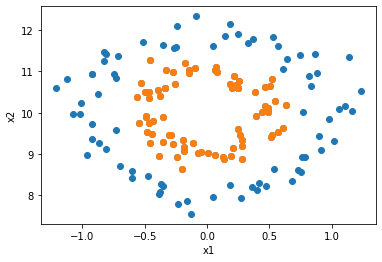

In [8]:
plt.plot(toy_beispiel.x1, toy_beispiel.x2,"o")
plt.plot( toy_beispiel.x1[toy_beispiel.y==1],  toy_beispiel.x2[toy_beispiel.y==1],"o")
plt.xlabel("x1")
plt.ylabel("x2")

Wie Sie sehen können, liegt die eine Klasse innerhalb der anderen. Wir wollen eine SVM trainieren, um die beiden Klassen voneinander zu unterscheiden.

Ihnen sollte auch auffallen, dass die Skalen der beiden Input Variablen `x1` und `x2` deutlich verschieden ist. 

`x1` Werte liegen ungefähr zwischen `-1` und `1`. <br>`x2` Werte befinden sich zwischen ca. `8` und `12`.

Wir werden zunächst die Daten nicht skalieren, und direkt eine SVM auf diese Daten trainieren. Dafür bietet das Modul `sklearn.svm` einige Funktionalitäten. Genau bei der linearen Regression mit `sklearn` wird erst das Model erstellt und dann wird s trainiert.
Die Funktion `SVC` (Support Vector Classification) kann für das Klassifizieren benutzt werden. Als Erstes erstellen wir eine Variable `model`. Diese enthält den Support Vector Classifier (`SVC`). Um diesen zu trainieren, nutzen wir die Funktion `.fit(x,y)` um den Klassifier an unseren Daten anzupassen. 

Bis jetzt haben wir den SVC nur trainiert, um seiner Vorhersagen zu erhalten, müssen wir noch einmal die Funktion `model.predict(x)` benutzen.


**Wichtig:** Vielleicht haben Sie es schon oben gesehen, in `pandas` können wir Variablen (also Spalten) direkt aus dem `DataFrame` auswählen. Also `toy_beispiel.y` wählt die Spalte `y` aus dem DataFrame `toy_beispiel` aus. 
Wollen Sie Werte mit der klassischen Indizierung, wie bei `arrays` auswählen, müssen Sie erste ein `.iloc[]` an den Namen des DataFrames hängen. Die Indizierung funktioniert dann genau wie bei `numpy`.

`toy_example.iloc[:,:2]` wählt die beiden ersten Spalten, also `x1` und `x2` aus.

In [10]:
from sklearn.svm import SVC

model = SVC()
model.fit(toy_beispiel.iloc[:,:2], toy_beispiel.y)
y_pred = model.predict(toy_beispiel.iloc[:,:2])
y_pred

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1])

Um die Güte der Vorhersagen zu beurteilen, können Sie wieder die Genauigkeit/Accuracy benutzen. Sie können dieselbe Funktion von letzter Woche dafür benutzen. Berechnen Sie Accuracy für die Vorhersagen dieses Modells. 

In [35]:
def accuracy(y_true, y_pred):
    return np.sum(y_true==y_pred)/len(y_true)

accuracy(_____, ____)

0.6866666666666666

<details>
    <summary><b>Lösung:</b></summary>

```python
accuracy(toy_beispiel.y, y_pred)
```
</details>

Die Accuracy ist um die `0.7`. Nicht schlecht aber das ist noch Luft nach oben. Mit einer der vorgeschriebenen Funktionen in `utils.py` können Sie auch die Decision Boundaries sichtbar machen. 

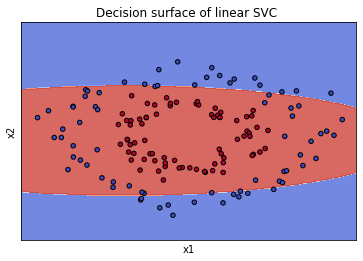

In [11]:
plot_svc(toy_beispiel, model)

Sie sehen, dass die Decision Boundary sehr langgezogen ist. Das liegt daran, dass die Skala von `x2` größer ist. Das heißt der Abstand von Decision Boundary zu Datenpunkten zweier Klassen (den es zu maximieren gilt) kann man leichter für `x2` als für `x1` maximieren. Deswegen sieht man eine gute Decision Boundary für die Werte von `x2` nicht aber für `x1`. 

Um das zu ändern, können wir probieren die Daten zu skalieren.
Hierfür benutzen wir den sogenannten `MinMax` Scaler bei dem alle Werte zwischen 0 und 1 skaliert werden. Wir wenden diesen Scaler auf beide Input Variablen an (`x1` `x2`). 

In [12]:
def min_max(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

toy_beispiel.x1 = min_max(toy_beispiel.x1)
toy_beispiel.x2 = min_max(toy_beispiel.x2)

Text(0, 0.5, 'x2')

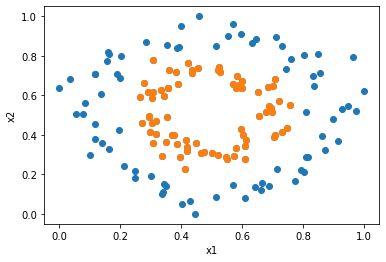

In [13]:
plt.plot(toy_beispiel.x1, toy_beispiel.x2,"o")
plt.plot( toy_beispiel.x1[toy_beispiel.y==1],  toy_beispiel.x2[toy_beispiel.y==1],"o")
plt.xlabel("x1")
plt.ylabel("x2")

Der Plot sieht insgesamt genau gleich aus, aber die Skalen, x- und y-Achse, haben Sich verändert. 
Das heißt, das relative Verhältnis der Werte hat sich nicht geändernt.
Können Sie jetzt ein `model_2` mit `SVC` erstellen, welches mit den skalierten Werten trainiert wird? Berechnen Sie auch die Accuracy!

In [ ]:
model_2 = ____
model_2.fit(_____, ______)
y_pred = model_2.predict(toy_beispiel._____)
accuracy(______,_____)

<details>
    <summary><b>Lösung:</b></summary>

```python
model_2 = SVC()
model_2.fit(toy_beispiel.iloc[:,:2], toy_beispiel.y)
y_pred = model.predict(toy_beispiel.iloc[:,:2])
accuracy(toy_beispiel.y, y_pred)
```
</details>

Nur durch das Skalieren der Inputvariablen erhalten Sie eine Verbesserung von 0,3 in der Genauigkeit.
Sie können auch anhand der Decision Boundary eine deutliche Verbesserung erkennen.

In [1]:
plot_svc(toy_beispiel, model_2)

NameError: name 'plot_svc' is not defined

Auch wenn die Daten nur für dieses Beispiel generiert wurden, zeigen sie dennoch warum das skalieren von Inputvariablen so wichtig ist.

# Train & Test Split

Von einem theoretischen Beispiel, kommen wir jetzt zum einer praktischen Augfagbe. Die toxikologische Vorhersage.
Wie am Anfang erwähnt haben wir die Assay Messung für verschiedene Moleküle bereit gestellt. Auch diese laden wir mit `pandas`.

In [14]:
data = pd.read_csv("../data/toxicity/sr-mmp.tab", sep = "\t")

print("Type:", type(data))
print("Shape:",data.shape)
data.head()

Type: <class 'pandas.core.frame.DataFrame'>
Shape: (2246, 3)


,Compound,SMILES,activity
0,NCGC00013012-01,OC(=O)[C@H](O)[C@@H](O)[C@H](O)C(=O)CO,0
1,NCGC00013034-01,C[C@]12CC[C@H]3[C@@H](CCc4cc(O)ccc43)[C@@H]1CC...,1
2,NCGC00013051-05,CC(C)(C)c1cc(O)ccc1O,1
3,NCGC00013058-01,CN(C)c1ccc(cc1)C(c1ccccc1)=C1C=CC(C=C1)=[N+](C)C,1
4,NCGC00013103-01,NC(Cc1ccccc1)C(O)=O,0


Die Daten enthalten drei Spalten: `Compound` `SMILES` und `activity`. Insgesamt enthält die Datei 2246 Moleküle.

-  `Compound` enthält die Bezeichnung(ID) mit der die Werte im originalen Datensatz unterschieden werden können
- `SMILES` enthält die SMILES strings
- `activity` die Information, ob ein Molekül aktiv (`1`) oder inaktiv (`0`) getestet worden ist

---
Falls Sie wissen wollen wie viele aktive und damit toxische Moleküle im Datensatz enthalten sind, können sie einfach die Summe der Spalte `activity`berechnen.

In [75]:
np.sum(data.activity) # data.activity wählt die in 'data' enthalten Spalte 'activity' aus

1123

Wie Sie sehen konnten, können Sie `DataFrame` Spalten auch ohne explizite Indizes auswählen. Dafür folgt auf den Namen des `DataFrames` ein `.` mit dem jeweiligen Namen der Spalte.

Für die Analyse ist die `Compounds` Spalte nicht wichtig. Darum wird sie aus `data` entfernt. Danach benennen wir noch die Spalten neu, damit alle kleingeschrieben werden.

In [22]:
data = data.iloc[:,1:] #alle Spalten bis auf die erste (index 0) werden ausgewählt
data.columns = ["smiles", "activity"]
data.head()

,smiles,activity
0,OC(=O)[C@H](O)[C@@H](O)[C@H](O)C(=O)CO,0
1,C[C@]12CC[C@H]3[C@@H](CCc4cc(O)ccc43)[C@@H]1CC...,1
2,CC(C)(C)c1cc(O)ccc1O,1
3,CN(C)c1ccc(cc1)C(c1ccccc1)=C1C=CC(C=C1)=[N+](C)C,1
4,NC(Cc1ccccc1)C(O)=O,0


Sie haben zwar Daten, aber immer noch keinen Input für ihre Model. Smiles sind `str` Variablen, aber Modelle brauchen numerische Variablen als Input. Das heißt, Sie müssen erst noch sogenannte Features erstellen. Dafür können Sie die Deskriptoren von letzter Woche benutzen. In der folgenden Zellen werden die SMILES zu `mol` konvertiert und mit denen die Deskriptoren berechnet. Diesmal berechnen wir noch zusätzlich die Molar Refractivity (Maß für die Gesamtpolarisierbarkeit), die Anzahl der drehbaren Bindung und die TPSA (topologische polare Oberfläche). Anschließend kombinieren wir alle Variablen zu einem `DataFrame`.

Passen Sie die `for loops` an:

In [11]:
# Wir konvertieren all Smiles zu mols
mols = np.array([Chem.MolFromSmiles(x) for x in ________ ]) # Welche Smiles müssen ausgewählt werden

# 1) N hydrogen bond donors
num_hb_donors = [NumHDonors(x) for x in _______ ] #durch welche Variable loopen wir durch

# 2) Hydrogen bond acceptors
num_hb_acceptors = [NumHAcceptors(x) for _____ in ______] #durch welche Variable loopen wir durch

# 3) Number of rotable bonds 
num_rotablebonds = [NumRotatableBonds(x) for x in mols]

# 4) Molecular Mass: CalcExactMolWt()
mw = [ _________(___ ) for x in mols]  # Berechnen Sie die das Geicht mit CalcExactMolWt()

# 5) log P: MolLogP()
logP = [________ ___ __ __ ______] #Berechnen Sie den logP mit MolLogP()

# 6) Molar refractivity 
mr = [MolMR(x) for x in mols]

# 7) Polar Surface
tpsa = [CalcTPSA(x) for x in mols]

aux_data=pd.DataFrame({
    "hb_donors": num_hb_donors,
    "hb_acceptors": num_hb_acceptors,
    "rotable_bonds": num_rotablebonds,
    "mw": mw,
    "logP": logP,
    "mr":mr,
    "tpsa":tpsa
    })

aux_data["activity"] = data.activity # Wir fügen noch die activity hinzu
aux_data


SyntaxError: invalid syntax (3639650274.py, line 17)

<details>
    <summary><b>Lösung:</b></summary>

```python
# Wir konvertieren all Smiles zu mols
mols = np.array([Chem.MolFromSmiles(x) for x in data.smiles])

# 1) N hydrogen bond donors
num_hb_donors = [NumHDonors(x) for x in mols]

# 2) Hydrogen bond acceptors
num_hb_acceptors = [NumHAcceptors(x) for x in mols]

# 3) Number of rotable bonds 
num_rotablebonds = [NumRotatableBonds(x) for x in mols]

# 4) Molecular Mass
mw = [CalcExactMolWt(x) for x in mols]

# 5) log P
logP = [MolLogP(x) for x in mols]

# 6) Molar refractivity 
mr = [MolMR(x) for x in mols]

# 7) Polar Surface
tpsa = [CalcTPSA(x) for x in mols]

aux_data=pd.DataFrame({
    "hb_donors": num_hb_donors,
    "hb_acceptors": num_hb_acceptors,
    "rotable_bonds": num_rotablebonds,
    "mw": mw,
    "logP": logP,
    "mr":mr,
    "tpsa":tpsa
    })

aux_data["activity"] = data.activity # Wir fügen noch die activity hinzu
aux_data
```
</details>

Der `DataFrame` `aux_data` hat für jeden Deskriptor eine eigene Spalte, also insgesamt sieben. Die erste Reihe enthält die Deskriptoren für das erste Molekül, die zweite für das zweite usw.
Diesen Datensatz können Sie jetzt verwenden, um ein Modell zu erstellen. 
Allerdings müssen noch ein paar extra Schritte unternommen werden, bevor Sie wirklich ein funktionierendes Modell haben und Vorhersagen treffen können.

Zunächst haben wir zwei Arten von Variablen. Variablen wie die Anzahl der drehbaren Bindungen werden als `discrete` beschrieben, da sie nur ganze Zahlen enthalten. Es gibt keine 3,5 dreh
bare Bindungen in einem Molekül. Im Gegensatz dazu sind Variablen wie logP oder TPSA `continous`, also Variablen die Werte über den ganzen Zahlenstrahl annehmen können. Zusätzlich haben wir Variablen mit unterschiedlichen Skalen. Werte für das Gewicht sind viel größer als z.B. Werte für den logP oder die Anzahl der HB Akzeptoren. 

Da wir aber als nächste ein Random Forest Modell benutzen brauchen, müssen die Variablen nicht skaliert werden.
Denn Random Forests benutzen weder Distanzen noch Gradienten.

In [25]:
# Zunächst teilen wir den Datensatz in 'x' und 'y' also input und output
x = aux_data.iloc[:,:7].values #'[:,:7]' Alle Spalten bis auf die 7 Spalte
y = aux_data.iloc[:,7].values #'[:,7]' Nur Spalte 7

Die neue `x` Variable ist nun ein Array (anstatt eines `DataFrames`). Sie können jetzt ein Random Forest Modell trainieren. Ähnlich wie bei dem `SVC`, müssen Sie erst eine Variable mit dem Modell erstellen und dann mit `.fit()` das Model auf die Daten trainieren.

In [26]:
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42) 
#n_estimators wählt aus wie viele Trees benutzt werden sollen
rf.fit(x, y)

RandomForestClassifier(n_estimators=1000, random_state=42)

Um zu sehen, wie gut das Model funktioniert, müssen Sie erst noch die Vorhersagen aus dem Model für unsere Daten extrahieren. Anders als sonst benutzen wir hierfür die Funktion <br>`.predict_proba(x)[:,1]`. Wir benutzen den trainierten `rf⁣`, um `y_hat` vorherzusagen.

In [27]:
y_hat=rf.predict_proba(x)[:,1]
y_hat

array([0.014     , 0.54678571, 0.60585222, ..., 0.98183333, 0.102     ,
       0.14995   ])

Die vorhergesagte Wahrscheinlichkeit vom ersten Molekül ist `0.014`. Wie bei der logistischen Regression heißt das, dass das Molekül laut unserem Model zu 1.4 %  auf dem MMP Assay aktiv sein wird, also wahrscheinlich nicht toxisch ist. Je höher die Wahrscheinlichkeit, desto wahrscheinlicher (laut dem Modell) ist das Molekül aktiv auf dem Assay. 
Oft wird als „Cut-Off" Wert 0.5 gewählt, also wir würden ab einem Wert von 0.5 davon ausgehen, dass das Modell diese Moleküle als toxisch ansieht. 

Um besser einschätzen zu können wie gut das Modell funktioniert, vergleichen Sie die vorhergesagten Werte `pred_y` mit den tatsächlichen Werten `y`.
Dafür können Sie zum Beispiel die *Genauigkeit* nehmen. Die Genauigkeit ist der Prozentsatz der richtig klassifizierten Moleküle. Dafür werden alle Wahrscheinlichkeiten größer gleich 0.5 aufgerundet und Wahrscheinlichkeiten kleiner als 0.5 abgerundet. Als letzten Schritt müssen Sie nur den Prozentsatz der Moleküle berechnen, bei dem die gerundeten Werte `pred_y` gleich der Werte in `y` sind.  

In [33]:
y_pred = np.round(y_hat)
accuracy(y, y_pred)

0.9915405164737311

Anschließend können wir den AUC mit der Funktion. `roc_auc_score()` berechnen. Der AUC misst wie gut unser Netzwerk im vorhersagen ist. Er vergleicht die Wahrscheinlichkeiten vom RF mit den tatsächlichen Werten für die Moleküle. Ein Wert von 1 bedeutet eine perfekte Vorhersage. Ein Wert von 0.5 bedeutet, dass das Netzwerk nicht besser als der Zufall ist.

Anders als für die `accuracy` benutzen wir hier die Wahrscheinlichkeiten `y_hat` anstatt die gerundeten Werte `y_pred`.

In [34]:
roc_auc_score(y, ____)

0.9997573602700437

<details>
    <summary><b>Lösung:</b></summary>

```python
roc_auc_score(y,y_hat)
```
</details>

Sehr gut. Das Model ist fast perfekt im Vorhersagen, ob ein Molekül aktiv ist. Es trifft zu 99 % der Fälle die richtige Entscheidung. In der folgenden Zelle werden die falsch klassifizierten Moleküle ausgewählt und mit ihrer vorhergesagten Wahrscheinlichkeit angezeigt. Es ist nicht unbedingt notwendig, dass Sie diesen Code verstehen. 

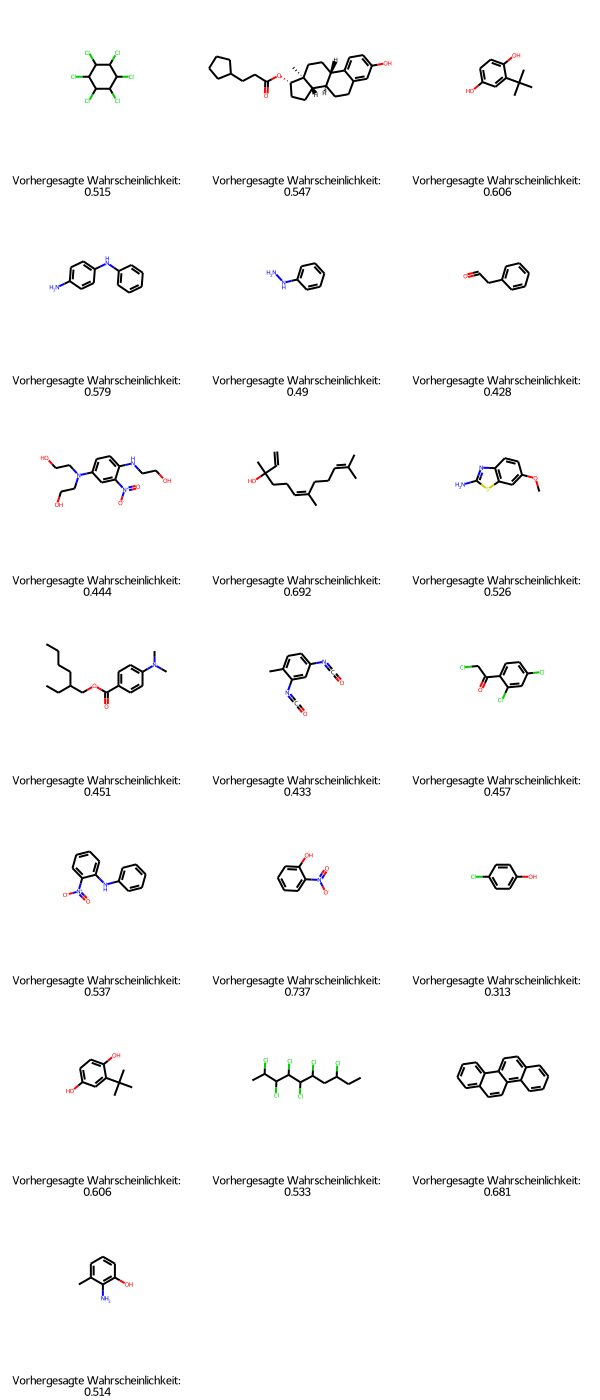

In [40]:
falsch_klassifizierte=np.where(y_pred!=y)[0]
Draw.MolsToGridImage(mols[falsch_klassifizierte],
                     legends=["Vorhergesagte Wahrscheinlichkeit:\n"+str(np.round(x,3)) for x in y_hat[falsch_klassifizierte]],
                     useSVG=True)

## Y-Scrambling

Was auffällt ist, dass die Wahrscheinlichkeiten für diese Moleküle meistens relativ nah an 0.5 sind. Das heißt, für diese Moleküle war sich das Modell nicht sehr sicher. Insgesamt wurden aber nur 19 Moleküle falsch klassifiziert, wir sollten uns also nicht all zu viele Sorgen machen.

Das Problem:

*Hat das Model wirklich gelernt, was wichtig ist für den MMP Assay. Oder hat das RF Modell unsere Daten einfach nur auswendig gelernt?*

Wir können das mit einem einfachen Test ausprobieren. Wir trainieren den RF noch einmal, bevor dies aber machen vertauschen wir die `activity` Variable. Das heißt, die echten Messungen werden gemischt und neu auf die Moleküle verteilt. Dieser Prozess wird auch **y-scrambling** genannt. 

Angenommen unsere echten Daten sehen wie folgt aus:

smiles|Deskriptor 1| Deskriptor 2|activity
------|------------|-------------|--------
SMILES 1|$x_{1,1}$ |$x_{1,2}$|$y_1$
SMILES 2|$x_{2,1}$ |$x_{2,2}$|$y_2$
SMILES 3|$x_{3,1}$ |$x_{3,2}$|$y_3$
SMILES 4|$x_{4,1}$ |$x_{4,2}$|$y_4$

Für jeden SMILES wurden 2 Deskriptoren berechnet. Wir haben auch die Aktivität($y_1$-$y_4$) für jedes Molekül aufgezeichnet. Die Aktivität $y_1$ ist die gemessene Aktivität von SMILES 1 usw.#

Nach dem *Y-scrambling* sehen unsere Daten so aus:

smiles|Deskriptor 1| Deskriptor 2|activity
------|------------|-------------|--------
SMILES 1|$x_{1,1}$ |$x_{1,2}$|$y_2$
SMILES 2|$x_{2,1}$ |$x_{2,2}$|$y_3$
SMILES 3|$x_{3,1}$ |$x_{3,2}$|$y_4$
SMILES 4|$x_{4,1}$ |$x_{4,2}$|$y_1$

Die $y$ Werte wurden zufällig anderen Molekülen zugeordnet.

Das Y-Scrambling führt dazu, dass die tatsächlichen Muster, die zwischen den `x` Variablen (also unseren Deskriptoren wie logP,...) und der Output Variable `y` bestehen, verloren gehen.  Das leigt daran, dass jetzt die Beziehung nur noch zufällig ist. Wenn unser Random Forest tatsächlich Muster lernt, anstatt die Daten auswendig zu lernen, dann sollte das Model auf diesem Datensatz schlechter funktionieren.

Um dies auszuprobieren brauchen Sie die library `random`. Mit der Funktion `random.shuffle()` werden die Werte von `y` zufällig neu sortiert. Sie können dann nochmal das Random Forest Modell trainieren.

In [43]:
import random
random.seed(15) #ein Seed stell sicher das Sie alle die selbe zufälligen Daten erhalten
y_random=np.array(y) # erst speichern wir y in einem array
random.shuffle(y_random) # dann shuffeln wir y-random, wir müssen diese Variable nicht extra speichern

Wir haben gerade die Aktivitätsinformation gemischt. Wir können jetzt ein Random Forest Model trainieren. Diesmal benutzen wir aber nicht `y`, sondern `y_random`.

In [45]:
# Das Model wird neu trainiert
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rf.fit(x, ______) # Welcher y Variable brauchen Sie
y_hat=rf.predict_proba(x)[:,1]

NameError: name '______' is not defined

<details>
    <summary><b>Lösung:</b></summary>

```python
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rf.fit(x, y_random) # Welcher y Variable brauchen Sie
y_hat=rf.predict_proba(x)[:,1]
```
</details>




Jetzt berechnen Sie erneut die Accuracy (achten Sie darauf, dass wir wieder `y_random` und nicht `y` für `y_true` benutzen):

In [49]:
y_pred = np.round(y_hat)
accuracy(y_random, y_pred)

0.9229741763134461

Tatsächlich verschlechtert sich die Genauigkeit nach dem Y-Scrambling. Aber trotzdem ist die Genauigkeit über 90 %. Das Random Forest Modell ist immer noch relativ gut im Vorhersagen der toxikologischen Bedenklichkeit, obwohl die Daten, die Sie benutzt haben, gar keinen Sinn mehr ergeben. Das Modell konnte gar nicht lernen, weil es gar nichts zu lernen gab. Also hat das RF Modell seine Genauigkeit nur durch das Auswendiglernen erreicht. 

Darum benutzen man **immer** ein Validierungsdatensatz. Dieses Validierungsset wird nicht im Training benutzt, und somit sieht das Model diese Moleküle bei der Bewertung zum ersten Mal. Auswendiglernen kann immer noch passieren, wird dem Model aber nicht bei dem Validierungsset helfen.  

---
Oft werden Datensätze nicht nur in Train/Validierungset geteilt, sondern in Train/Validierung/Testset.
Die Modelle werden dann anhand des Validierungsset optimiert und nur das optimierte Model wird dann auf dem Testset getestet.
Technisch gesehen müsste das hier verwendetet Validierungsset Testset heißen, da wir keine Modelloptimierung betreiben. Damit aber für die folgenden Wochen die Terminologie einheitlich bleibt, nennen wir es Validierungset.

---
Auch hier gibt es wieder Funktionen, die Ihnen die Arbeit abnehmen. `train_test_split` teilt die Daten in ein Test(hier Validierungsset) und ein Trainingset. Wir benutzen 80 % des Datensatzes für das Training und die restlichen für das Validierungsset. Die Moleküle werden dann zufällig zwischen den beiden Sets aufgeteilt. Danach werden die Daten wieder in `x` und `y` getrennt, diesmal aber für `train` und `val` separat.



In [58]:
train, val=train_test_split(aux_data,test_size= 0.2, train_size= 0.8, random_state=1234)

train_x = train.iloc[:,:7]
train_y = train.iloc[:,7]
val_x = val.iloc[:,:7]
val_y =  val.iloc[:,7]
f"Train Shape: {train.shape}, Val Shape: {val.shape}"

'Train Shape: (1796, 8), Val Shape: (450, 8)'

Der Trainingssatz enthält nur noch 1796 Moleküle und das Validationset 450. 

Wir trainieren zunächst den Random Forest nur mit den Trainingsdaten:

In [59]:
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rf.fit(train_x, train_y)

RandomForestClassifier(n_estimators=1000, random_state=42)

Die Vorhersagen machen wir aber nur für die Moleküle im Validerungsset.

In [56]:
y_hat=rf.predict_proba(val_x)[:,1]
y_pred = np.round(y_hat)

Wir können hetzt auch die Genauigkeit berechnen. Welche Variable brauchen wir jetzt für `y_true`?

In [61]:
accuracy(___, y_pred)

0.8111111111111111

<details>
    <summary><b>Lösung:</b></summary>

```python
accuracy(y_val, y_pred)
```
</details>

Die Genauigkeit hat sich um einiges verschlechtert, ist aber immer noch gut. Allerdings können wir uns diesmal sicher sein, dass die Performance nicht durch Auswendiglernen zustande kam, da das Model vorher nie diese Moleküle gesehen hat. Wenn wir jetzt den Y-Scrambling Test anwenden, sollte die Performance drastisch schlechter werden. 
Wir ersten die `aux_data.activity` mit den vorhin erstellten `y_random`. Das sind die gemischten `y` Werte und wiederholen die Analyse.

In [62]:
aux_data.activity = y_random 

0.8111111111111111

Danach teilen wir wieder die Daten in Trainings- und Validierungsset ein.

In [64]:
train_random, val_random=train_test_split(aux_data,test_size= 0.2, train_size= 0.8, random_state=1234)
train_x_random = train_random.iloc[:,:7]
train_y_random = train_random.iloc[:,7]
val_x_random = val_random.iloc[:,:7]
val_y_random =  val_random.iloc[:,7]

Wir wiederholen wieder das trainieren mit den randomisierten Daten. Danach lassen wir das Model vorhersagen für das Validierungsset machen.

In [66]:
# Train Model
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rf.fit(train_x_random, train_y_random)
y_hat=rf.predict_proba(val_x_random)[:,1]

0.5266666666666666

Als letztes berechnen wir noch die Genauigkeit. 

In [ ]:
y_pred = np.round(y_hat)
accuracy(val_y_random, y_pred)

Mit dem Benutzen eines Validierungsset fällt die Genauigkeit des Modells mit den Y-scrambled Daten drastisch auf ungefähr 50 %. Es ist nicht besser als ein Model, das einfach raten würde.
Erst durch das Benutzen eines Validierungsset konnten wir zeigen, dass das Modell etwas über das Auswendiglernen hinaus gelernt hat.

Vor allem ging es darum zu zeigen, wie wichtig es ist, ein Model nicht auf dem Trainingsset zu bewerten. <br><br>
Das Y-Scrambeling wird nur selten in der Praxis benutzt. Aber die OECD fordert zum Beispiel, einen Y-Scrambling Test für das Validieren von Quantitive Structure-activity Relationship (QSAR) Models.

## Feature Importance

Als letzten Schritt schauen wir uns noch einmal die Feature Importance an. Die Feature Importance beurteilt, wie wichtig die einzelnen Variablen zur Entscheidung sind. Abhängig von welchem Machine Learning Algorithmus man benutzt kann man dies relativ leicht einsehen.<br> <br>

<AxesSubplot:>

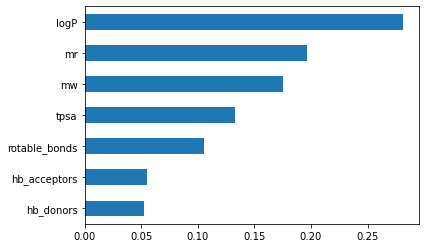

In [21]:
rf.fit(train_x, train_y)
paux_data.activity = data.activity

train, val=train_test_split(aux_data,test_size= 0.2, train_size= 0.8, random_state=1234)
train_x = train.iloc[:,:7]
train_y = train.iloc[:,7]
val_x = val.iloc[:,:7]
val_y =  val.iloc[:,7]




# Train Model
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
y_hat=rf.predict_proba(val_x)[:,1]


In der nächsten Zelle trainieren wir zuerst noch einmal das Random Forest Modell (ohne y scrambling) und lassen uns dann in den letzten beiden Zeilen die Feature Importance anzeigen.

In [ ]:
feat_importances = pd.Series(rf.feature_importances_, index=aux_data.columns.values[:-1])
feat_importances.nlargest(20).nsmallest(20).plot(kind='barh')

Es wird deutlich ersichtlich, dass der LogP der wichtigste Parameter für die Bestimmung der Toxizität ist, während die Anzahl an H-Brücken-Donoren und -Akzeptoren weniger relevant ist. <br><br> Da wir für Menschen verständliche Deskriptoren als Features gewählt haben, können wir uns auch gut anschauen welchen Einfluss ein einzelner Parameter auf die Aktivität hat (das hätten wir auch tatsächlich schon vor dem Trainieren machen können). <br><br> Zuerst lassen wir uns die Aktivitätsverteilung in Abhängigkeit vom LogP anzeigen.

<AxesSubplot:xlabel='logP', ylabel='Density'>

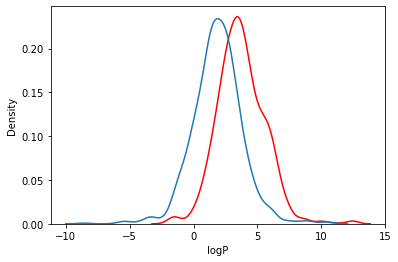

In [43]:
import seaborn as sns
sns.kdeplot(aux_data.logP[aux_data.activity==1], color="red")
sns.kdeplot(aux_data.logP[aux_data.activity==0])

Hier sehen wir einen deutlichen Trend. Bei höherem LogP ist das Molekül wahrscheinlicher aktiv. <br> <br>Probieren sie das einmal selbst mit den anderen Deskriptoren aus (`hb_donors`, `hb_acceptors`, `rotable_bonds`, `mw`, `mr`, `tpsa`). Welche Deskriptoren zeigen außer dem LogP noch unterschiedlich verteilte Aktivitäten?

# Übungsaufgabe 

Sie haben ja bereits Fingerprints als Molekülrepresentationen kennengelernt. Da diese einfach zu berechnen sind und immer eine fest definierte Länge haben, sind sie gut als Features für Machine Learning geeignet. Allerdings sind Fingerprints weniger schwieriger für Menschen zu interpretieren.

Ihre Aufgabe wird es sein, nochmals ein random Forest Modell zu trainieren. Diesmal werden Sie die Fingerprints als Input nehmen.

<br><br>Für Sie wurde die `get_fingerprints()` Funktion schon vorgeschrieben. Mit der lassen sich Fingerprints aus den SMILES berechnen.

In [7]:
fps = get_fingerprints(data)
fps["activity"] = data.activity
fps.head()

NameError: name 'data' is not defined

`fps` enthält insgesamt 2049 Spalten. 2048 davon sind die jeweiligen Bits des Fingerprints. Die letzte Spalte enthält die `activity`.

Teilen Sie zunächst den Datensatz in `train` und `test`. 80% der Daten sollen in das Trainingsset und 20 % in das Validierungsset.

In [ ]:
train, val=train_test_split(_____,test_size= ___ , train_size= ______, random_state=1234)

train_x = __________
train_y = __________
val_x = __________
val_y = __________ 

Nachdem Sie die Daten geteilt haben, trainieren Sie einen Random Forest Classifier mit Hilfe des Trainingsdatensatz.
Mit dem trainierten Modell, klassifzieren Sie dann die Moleküle im Test Datensatz `val`.

In [8]:
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rf.fit(_____.values, _____.values)
pred_y=rf.predict_proba(______)[:,1]

NameError: name '_____' is not defined

Berrechnen Sie den ROC-AUC.

In [ ]:
print(roc_auc_score(val_y,pred_y))

Wir können uns auch wieder die Feature Importance anschauen

In [ ]:
feat_importances = pd.Series(rf.feature_importances_, index=range(2048))
feat_importances.nlargest(20).nsmallest(20).plot(kind='barh', title = "Importance of Features")

Dieser Plot lässt sich leider nicht mehr so gut interpretieren, auch wenn deutlich wird, dass die obersten fünf Bits wichtig für die Aktivität sind. Leider kann man die Bits nicht so gut darstellen, aber es lassen sich die Fragmente, die jedem Bit zugeordnet sind mit RDKit zeigen:

[1602 1873 1380  875 1750  202  650  745   80 1313 1917 1607 1199  561
 1778 1088  807 1274 1195  352]


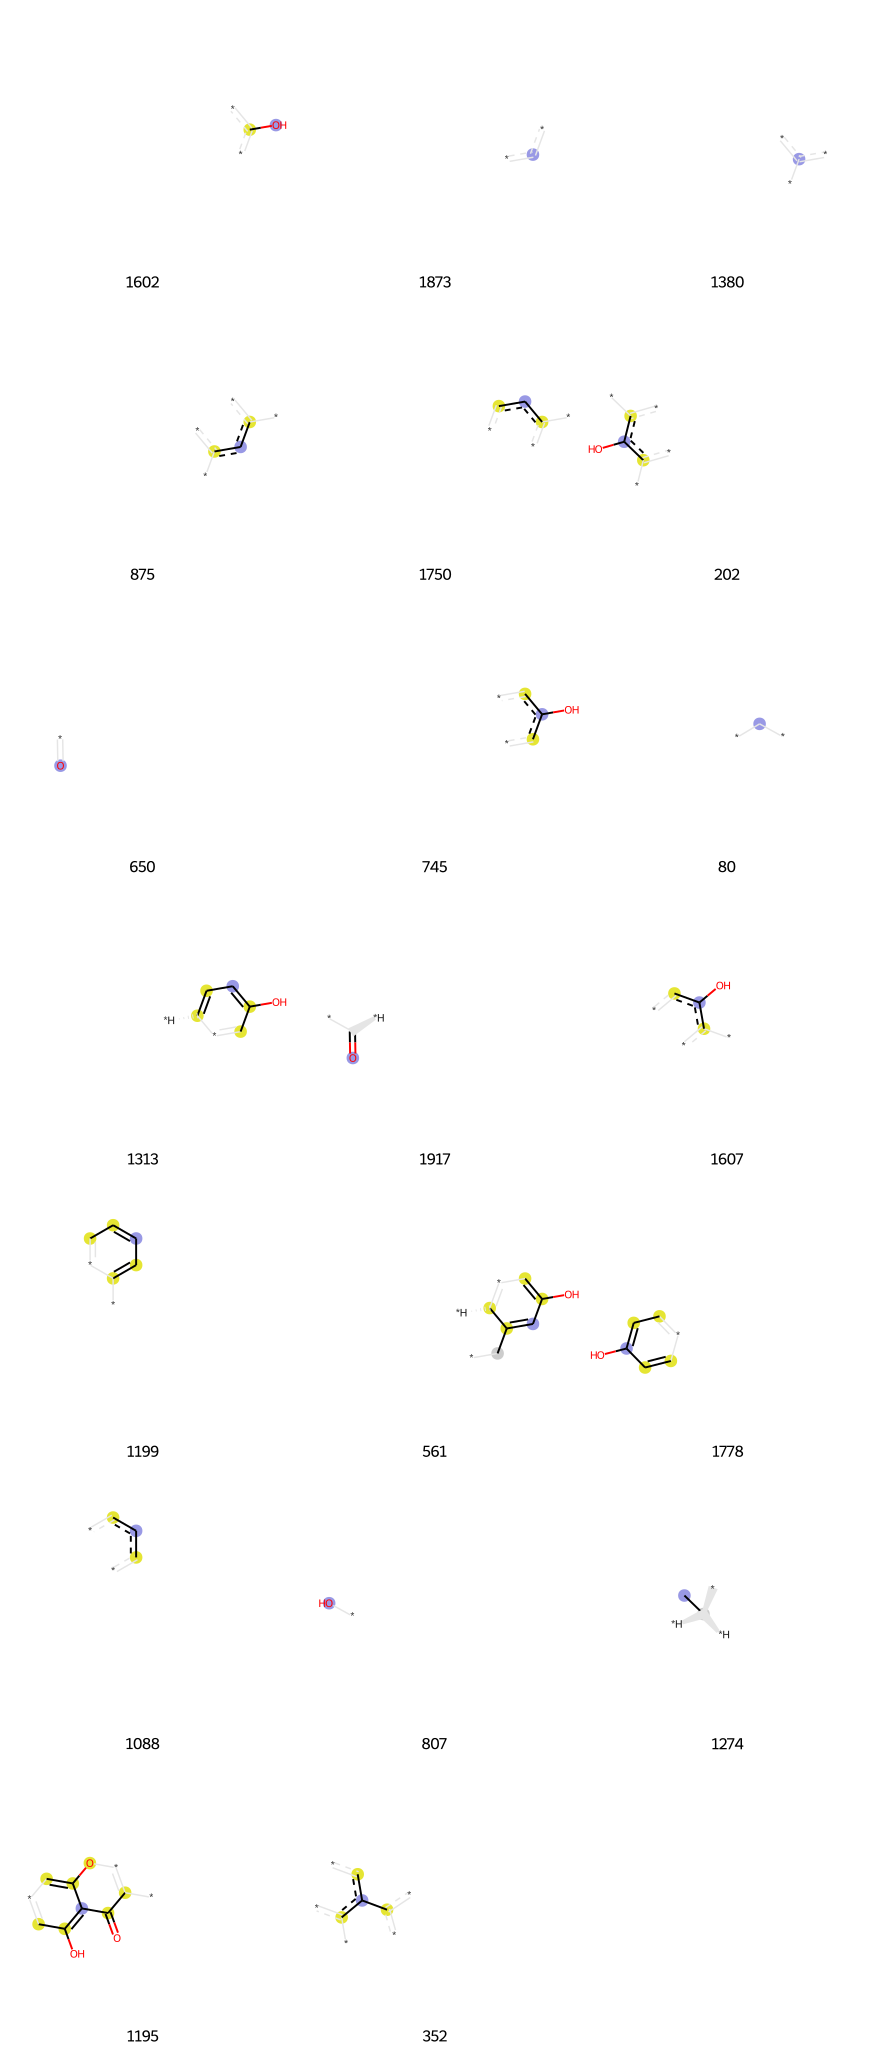

In [25]:
most_important_bits = feat_importances.nlargest(20).index.values
print("Die 20 wichtigsten bits:", most_important_bits)
mol_ll = []
bi_ll = []


for i in range(20):
    bit = most_important_bits[i]
    for x in data.smiles:
        bi ={}
        mol = Chem.MolFromSmiles(x)
        fp = Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, bitInfo=bi)
        if np.sum(np.array(list(bi))==bit)>0:
            mol_ll.append(mol)
            bi_ll.append(bi)
            break
        
prints=[(mol_ll[i],most_important_bits[i], bi_ll[i]) for i in range(20)]

Draw.DrawMorganBits(prints, useSVG=True, molsPerRow=3, legends= [str(most_important_bits[i]) for i in range(20)], subImgSize= [300,300])

Das wichtigste Bit ist für unsere Daten eine phenolische Hydroxygruppe (aromatische Atome sind gelb hervorgehoben, das zentrale Atom ist blau). Auch sonst sind viele aromatische Fragmente in den wichtigsten Bits vertreten.